# Camera Caliberation using Zhangs' method 

## Distortion :
Pinhole cameras introduce significant distortion to images. Two major kinds of distortion are radial distortion and tangential distortion.

Radial distortion causes straight lines to appear curved. Radial distortion becomes larger the farther points are from the center of the image.

Radial distortion can be represented as follows:

        xdistorted=x(1+k1r^2+k^2r^4+k3r^6)
        ydistorted=y(1+k1r^2+k2r^4+k3r^6)

tangential distortion occurs because the image-taking lense is not aligned perfectly parallel to the imaging plane. So, some areas in the image may look nearer than expected. The amount of tangential distortion can be represented as below:

        xdistorted=x+(2*p1*x*y+p2(r^2+2*x^2))
        ydistorted=y+ p1(r^2+2*y^2)+2*p2*xy)

We need to find five parameters, known as distortion coefficients given by:

        Distortioncoefficients=(k1,k2,p1,p2,k3)
        
We need to some other information, like the intrinsic and extrinsic parameters of the camera. Intrinsic parameters are specific to a camera. They include information like focal length ( fx,fy) and optical centers ( cx,cy).

        cameramatrix=[[fx,0,cx],[0,fy,cy],[0,0,1]]
        
Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

To find these parameters, we provide some sample images of a well defined pattern (e.g. a chess board). We find some specific points of which we already know the relative positions (e.g. square corners in the chess board). We know the coordinates of these points in real world space and we know the coordinates in the image, so we can solve for the distortion coefficients.

## Steps :
1. Read 12 chessboard pattern images each has chessboard of 9x7 boxes.
2. Create 3-D image points with z=0 plane, which would correspond to 2-D image corners on the chessboard.
3. Find the corners of the chessboard which would correspond to coordinates of image plae.
4. Draw these corners on the images.

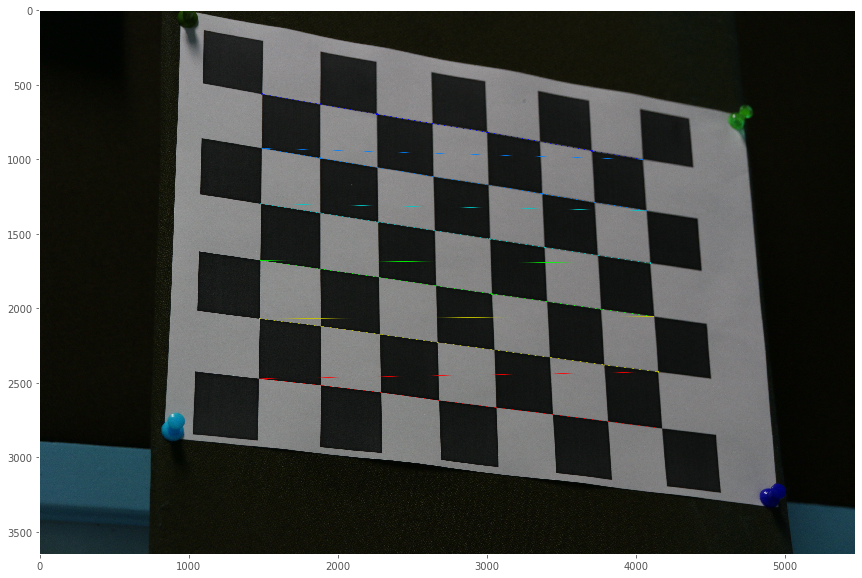

In [26]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
#from matplotlib import style
#style.use("ggplot")

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((8*6,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('dataset/*.JPG') #("mycam_data/chessboard_1x/*.jpg")
img_to_show= []
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (8,6), None)
    #print(ret)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (8,6), corners2, ret)
        img_to_show = img
        cv.imwrite("img_"+str(15)+".jpg", img)
        cv.imshow('img', img)
        #cv.waitKey(500)
cv.destroyAllWindows()
plt.figure(figsize=(15,10))
plt.grid(b=None)
plt.imshow(img_to_show);
plt.show();
cv.destroyAllWindows()

5. Find the camera matrix, distortion coefficients, rotation and translation vectors for each image provided.

## The image of world origin is is the 4th column of the 3x4 caliberation matrix

In [27]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print(ret)
print("Camera matrix :\n", mtx)
print("Distortion matrix :\n",dist)
print("Rotation matrix for 1st image:\n",rvecs[0])
print("Translation matrix for 1st image :\n",tvecs[0])

Camera matrix :
 [[1.36415094e+04 0.00000000e+00 3.31635881e+03]
 [0.00000000e+00 1.36632517e+04 1.50037396e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion matrix :
 [[ 9.79057908e-02  9.45876425e+00 -1.53012034e-02  2.72096493e-02
  -1.48434591e+02]]
Rotation matrix for 1st image:
 [[-0.01040574]
 [-0.04719484]
 [-0.00305521]]
Translation matrix for 1st image :
 [[-5.09954028]
 [-2.0599507 ]
 [30.85011107]]


6. Using the  camera matrix, distortion coefficients, rotation and translation vector found above, project the 3-D world points on the image to get the chessboard corners.
7. Draw the wireframe on the image to show the projected points.

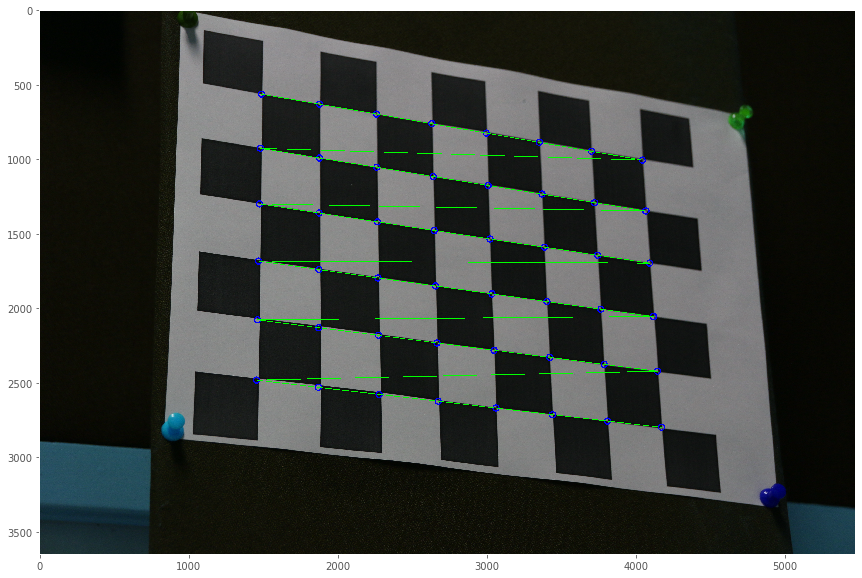

In [29]:
img_to_show= []
for i in range(len(images)):
    img = cv.imread(images[i])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    dst, jacobian = cv.Rodrigues(rvecs[i])
    #print(rvecs[i].shape, dst.shape)
    P = np.dot(mtx, dst)
    t = np.dot(mtx,tvecs[i])
    points_plot = []
    for j in range(len(objpoints[0])):
        xy = np.dot(P,np.c_[objpoints[i][j]]) + t#np.transpose(np.dot(P,tvecs[i]))
        xy = (xy/xy[2][0])
        points_plot.append((int(xy[0][0]), int(xy[1][0])))
    img = cv.circle(img, points_plot[0], radius=20, color=(0,0,255), thickness=8)
    for pt in range(len(points_plot)-1):
        img = cv.circle(img, points_plot[pt+1], radius=20, color=(0,0,255), thickness=8) 
        img = cv.line(img, points_plot[pt], points_plot[pt+1], color=(0,255,0), thickness=4) 
        img_to_show = img
    cv.imshow('img', img)
    cv.imwrite("q2_op/img_"+str(i)+".jpg", img)
    #cv.waitKey(500)

plt.figure(figsize=(15,10))
plt.grid(b=None)
plt.imshow(img_to_show)
plt.show();
cv.destroyAllWindows()